# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from stats232a.classifiers.cnn import *
from stats232a.classifiers.resnet import *
from stats232a.data_utils import get_CIFAR10_data
from stats232a.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from stats232a.layers import *
from stats232a.fast_layers import *
from stats232a.solver import Solver
from stats232a.layer_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `stats232a/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `stats232a/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [4]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  2.2441985546607075e-09
dw error:  9.747020450039863e-10
db error:  4.3909013393193666e-11


# Max pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `stats232a/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [5]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `stats232a/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [6]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `stats232a/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `stats232a` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [14]:
from stats232a.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

KeyboardInterrupt: 

In [8]:
from stats232a.fast_layers import max_pool_forward_fast, max_pool_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.304716s
fast: 0.004022s
speedup: 75.768971x
difference:  0.0

Testing pool_backward_fast:
Naive: 1.069761s
speedup: 27.367848x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `stats232a/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [9]:
from stats232a.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802401370096438e-09
db error:  1.0146343411762047e-09


In [10]:
from stats232a.layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `stats232a/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [24]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.30258631877538
Initial loss (with regularization):  2.5086860014666543


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [26]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [27]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Epoch 0 / 15, iteration 1 / 30) train acc: 0.190000; val_acc: 0.128000
(Epoch 1 / 15, iteration 2 / 30) train acc: 0.230000; val_acc: 0.094000
(Epoch 1 / 15, iteration 3 / 30) train acc: 0.380000; val_acc: 0.147000
(Epoch 2 / 15, iteration 4 / 30) train acc: 0.310000; val_acc: 0.098000
(Epoch 2 / 15, iteration 5 / 30) train acc: 0.490000; val_acc: 0.174000
(Epoch 3 / 15, iteration 6 / 30) train acc: 0.570000; val_acc: 0.191000
(Epoch 3 / 15, iteration 7 / 30) train acc: 0.610000; val_acc: 0.193000
(Epoch 4 / 15, iteration 8 / 30) train acc: 0.570000; val_acc: 0.194000
(Epoch 4 / 15, iteration 9 / 30) train acc: 0.560000; val_acc: 0.169000
(Epoch 5 / 15, iteration 10 / 30) train acc: 0.740000; val_acc: 0.188000
(Epoch 5 / 15, iteration 11 / 30) train acc: 0.770000; val_acc: 0.216000
(Epoch 6 / 15, iteration 12 / 30) train acc: 0.820000; val_acc: 0.256000
(Epoch 6 / 15, iteration 13 / 30) train acc: 0.850000; val_acc: 0.242000
(Epoch 7 / 15, iteration 14 / 30) train acc: 0.860000; val_a

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

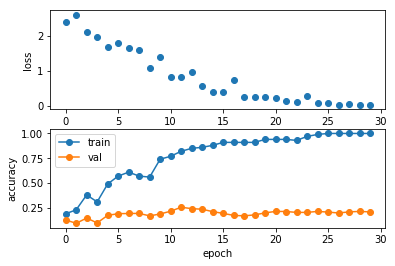

In [28]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [29]:
model = ThreeLayerConvNet(reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Epoch 0 / 1, iteration 1 / 980) train acc: 0.099000; val_acc: 0.119000
(Epoch 0 / 1, iteration 21 / 980) train acc: 0.242000; val_acc: 0.233000
(Epoch 0 / 1, iteration 41 / 980) train acc: 0.247000; val_acc: 0.266000
(Epoch 0 / 1, iteration 61 / 980) train acc: 0.273000; val_acc: 0.283000
(Epoch 0 / 1, iteration 81 / 980) train acc: 0.334000; val_acc: 0.348000
(Epoch 0 / 1, iteration 101 / 980) train acc: 0.326000; val_acc: 0.361000
(Epoch 0 / 1, iteration 121 / 980) train acc: 0.354000; val_acc: 0.350000
(Epoch 0 / 1, iteration 141 / 980) train acc: 0.362000; val_acc: 0.367000
(Epoch 0 / 1, iteration 161 / 980) train acc: 0.367000; val_acc: 0.373000
(Epoch 0 / 1, iteration 181 / 980) train acc: 0.334000; val_acc: 0.373000
(Epoch 0 / 1, iteration 201 / 980) train acc: 0.382000; val_acc: 0.375000
(Epoch 0 / 1, iteration 221 / 980) train acc: 0.357000; val_acc: 0.368000
(Epoch 0 / 1, iteration 241 / 980) train acc: 0.367000; val_acc: 0.377000
(Epoch 0 / 1, iteration 261 / 980) train acc

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

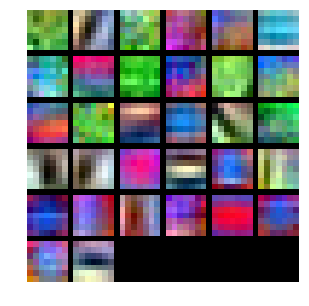

In [30]:
from stats232a.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Residual Net
Now let's try to build a residual network with one residual block.

Open the file `stats232a/classifiers/resnet.py` and complete the implementation of the `OneBlockResnet` class. Again firstly try to train your model with just a few training samples. You should be able to overfit small datasets by the following check:

In [18]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = OneBlockResnet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=25, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=2)
solver.train()

(Epoch 0 / 25, iteration 1 / 50) train acc: 0.250000; val_acc: 0.107000
(Epoch 1 / 25, iteration 2 / 50) train acc: 0.170000; val_acc: 0.113000
(Epoch 1 / 25, iteration 3 / 50) train acc: 0.110000; val_acc: 0.107000
(Epoch 2 / 25, iteration 4 / 50) train acc: 0.270000; val_acc: 0.129000
(Epoch 2 / 25, iteration 5 / 50) train acc: 0.320000; val_acc: 0.149000
(Epoch 3 / 25, iteration 6 / 50) train acc: 0.270000; val_acc: 0.120000
(Epoch 3 / 25, iteration 7 / 50) train acc: 0.230000; val_acc: 0.132000
(Epoch 4 / 25, iteration 8 / 50) train acc: 0.270000; val_acc: 0.137000
(Epoch 4 / 25, iteration 9 / 50) train acc: 0.260000; val_acc: 0.145000
(Epoch 5 / 25, iteration 10 / 50) train acc: 0.260000; val_acc: 0.143000
(Epoch 5 / 25, iteration 11 / 50) train acc: 0.270000; val_acc: 0.142000
(Epoch 6 / 25, iteration 12 / 50) train acc: 0.270000; val_acc: 0.145000
(Epoch 6 / 25, iteration 13 / 50) train acc: 0.250000; val_acc: 0.146000
(Epoch 7 / 25, iteration 14 / 50) train acc: 0.260000; val_a

## Train the net
By training the residual network for one epoch, you should achieve greater than 50% accuracy on the validation set:

In [19]:
model = OneBlockResnet(reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=50)
solver.train()

(Epoch 0 / 1, iteration 1 / 980) train acc: 0.113000; val_acc: 0.117000
(Epoch 0 / 1, iteration 51 / 980) train acc: 0.265000; val_acc: 0.273000
(Epoch 0 / 1, iteration 101 / 980) train acc: 0.327000; val_acc: 0.331000
(Epoch 0 / 1, iteration 151 / 980) train acc: 0.348000; val_acc: 0.345000
(Epoch 0 / 1, iteration 201 / 980) train acc: 0.387000; val_acc: 0.412000
(Epoch 0 / 1, iteration 251 / 980) train acc: 0.413000; val_acc: 0.447000
(Epoch 0 / 1, iteration 301 / 980) train acc: 0.425000; val_acc: 0.445000
(Epoch 0 / 1, iteration 351 / 980) train acc: 0.412000; val_acc: 0.436000
(Epoch 0 / 1, iteration 401 / 980) train acc: 0.415000; val_acc: 0.452000
(Epoch 0 / 1, iteration 451 / 980) train acc: 0.443000; val_acc: 0.430000
(Epoch 0 / 1, iteration 501 / 980) train acc: 0.472000; val_acc: 0.447000
(Epoch 0 / 1, iteration 551 / 980) train acc: 0.466000; val_acc: 0.477000
(Epoch 0 / 1, iteration 601 / 980) train acc: 0.482000; val_acc: 0.464000
(Epoch 0 / 1, iteration 651 / 980) train 